# 导入包和数据

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline
# %matplotlib widget
plt.rcParams['font.sans-serif'] = 'SimHei'  # 中文问题
plt.rcParams['axes.unicode_minus'] = False  # 负号问题
%config InlineBackend.figure_format = 'svg'

In [2]:
# def reduce_mem_usage(df):
#     """
#     function：来自kaggle，遍历数据框的所有列并修改数据类型 减少内存使用量。
#     Parameters：
#         df：数据集 DataFrame
#     """
#     start_mem = df.memory_usage().sum() / 1024**2
#     print('数据集原始大小是 {:.2f} MB'.format(start_mem))

#     for col in df.columns:
#         col_type = df[col].dtype

#         if col_type != object:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

#     end_mem = df.memory_usage().sum() / 1024**2
#     print('压缩后的数据集大小是 {:.2f} MB'.format(end_mem))
#     print('降低了{:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

#     return df

In [3]:
# user_action = pd.read_csv('dataset/jdata_action.csv')
# # user_action = reduce_mem_usage(user_action)

In [4]:
# # 数据集太大，本次仅截取部分并保存
# user_data = user_action[(user_action['action_time'] > '2018-03-30')
#                         & (user_action['action_time'] < '2018-04-15')]
# user_data.to_csv('dataset/my_user_data.csv', sep=',')

# 浏览数据

In [5]:
# 查看数据类型
data = pd.read_csv('dataset/my_user_data.csv')
data = data[['user_id', 'sku_id', 'action_time', 'module_id', 'type']]
data.head(10)

,user_id,sku_id,action_time,module_id,type
0,1455298,208441,2018-04-11 15:21:43,6190659,1
1,1455298,334318,2018-04-11 15:14:54,6190659,1
2,1455298,237755,2018-04-11 15:14:13,6190659,1
3,1455298,6422,2018-04-11 15:22:25,6190659,1
4,1455298,268566,2018-04-11 15:14:26,6190659,1
5,1455298,115915,2018-04-11 15:13:35,6190659,1
6,1455298,208254,2018-04-11 15:22:16,6190659,1
7,1455298,177209,2018-04-14 14:09:59,6628254,1
8,1455298,71793,2018-04-14 14:10:29,6628254,1
9,1455298,141950,2018-04-12 15:37:53,10207258,1


In [6]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7540394 entries, 0 to 7540393
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      7540394 non-null  int64 
 1   sku_id       7540394 non-null  int64 
 2   action_time  7540394 non-null  object
 3   module_id    7540394 non-null  int64 
 4   type         7540394 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 287.6+ MB


In [7]:
data.describe()

,user_id,sku_id,module_id,type
count,7.540394e+06,7.540394e+06,7.540394e+06,7.540394e+06
mean,8.033725e+05,1.890894e+05,6.202712e+06,1.452293e+00
std,4.654598e+05,1.085908e+05,3.435805e+06,1.132476e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.987740e+05,9.588500e+04,3.188662e+06,1.000000e+00
50%,8.028010e+05,1.881520e+05,6.381248e+06,1.000000e+00
75%,1.208782e+06,2.829740e+05,9.574079e+06,1.000000e+00
max,1.608707e+06,3.784570e+05,1.136361e+07,5.000000e+00


# 数据预处理

In [8]:
# 提取日期
data['action_time'] = pd.to_datetime(data['action_time'], format='%Y-%m-%d %H:%M:%S')
data['date'] = data['action_time'].dt.date
data['hour'] = data['action_time'].dt.hour
data['weekday'] = data['action_time'].dt.day_name()

In [9]:
# 删除无用列
data = data.drop('module_id', axis=1)

## 对大数据进行压缩处理

In [10]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b/1024**2
    return '{:03.2f} MB'.format(usage_mb)

In [11]:
# 向下转化为无符号整数
data_int = data.select_dtypes(include=['int64'])
data_newint = data_int.apply(pd.to_numeric, downcast='unsigned')
print(mem_usage(data_int))
print(mem_usage(data_newint))

230.11 MB
71.91 MB


In [12]:
data_obj = data.select_dtypes(include=['object'])
data_obj.nunique()

action_time    1669414
date                16
weekday              7
dtype: int64

In [13]:
# object对象若具有少量类别，则可以转换为category类型节省大量空间！
data_obj = data.select_dtypes(include=['object'])
data_newobj = data_obj.astype('category')
print(mem_usage(data_obj))
print(mem_usage(data_newobj))

1296.34 MB
244.94 MB


In [14]:
behavior = pd.concat([data_newint, data_newobj], axis=1)
print(mem_usage(behavior))

316.85 MB


In [15]:
behavior_type = {1: 'pv', 2: 'pay', 3: 'fav', 4: 'comm', 5: 'cart'}
behavior['type'] = behavior['type'].apply(lambda x: behavior_type[x])
behavior.head(10)

,user_id,sku_id,type,hour,action_time,date,weekday
0,1455298,208441,pv,15,2018-04-11 15:21:43,2018-04-11,Wednesday
1,1455298,334318,pv,15,2018-04-11 15:14:54,2018-04-11,Wednesday
2,1455298,237755,pv,15,2018-04-11 15:14:13,2018-04-11,Wednesday
3,1455298,6422,pv,15,2018-04-11 15:22:25,2018-04-11,Wednesday
4,1455298,268566,pv,15,2018-04-11 15:14:26,2018-04-11,Wednesday
5,1455298,115915,pv,15,2018-04-11 15:13:35,2018-04-11,Wednesday
6,1455298,208254,pv,15,2018-04-11 15:22:16,2018-04-11,Wednesday
7,1455298,177209,pv,14,2018-04-14 14:09:59,2018-04-14,Saturday
8,1455298,71793,pv,14,2018-04-14 14:10:29,2018-04-14,Saturday
9,1455298,141950,pv,15,2018-04-12 15:37:53,2018-04-12,Thursday


# 构建分析指标

## 流量分析指标

### PV UV

In [16]:
# 总访问量
pv = behavior[behavior['type'] == 'pv']['user_id'].count()
# 总访客数
uv = behavior['user_id'].nunique()
# 消费用户
user_pay = behavior[behavior['type'] == 'pay']['user_id'].unique()
# 日均访问量
pv_per_day = pv / behavior['date'].nunique()
# 人均访问量
pv_per_user = pv / uv
# 消费用户访问量（消费者-访问的）
pv_pay = behavior[behavior['user_id'].isin(
    user_pay)]['type'].value_counts()['pv']
# 消费用户占比
user_pay_rate = len(user_pay) / uv
# 消费用户访问量占比
pv_pay_rate = pv_pay / pv
# 消费用户人均访问量
pv_per_buy_user = pv_pay / len(user_pay)

In [17]:
print('总访问量为 %i' % pv)
print('总访客数为 %i' % uv)
print('消费用户数为 %i' % len(user_pay))
print('消费用户访问量为 %i' % pv_pay)
print('日均访问量为 %.3f' % pv_per_day)
print('人均访问量为 %.3f' % pv_per_user)
print('消费用户人均访问量为 %.3f' % pv_per_buy_user)
print('消费用户数占比为 %.3f%%' % (user_pay_rate * 100))
print('消费用户访问量占比为 %.3f%%' % (pv_pay_rate * 100))

总访问量为 6229177
总访客数为 728959
消费用户数为 395874
消费用户访问量为 3918000
日均访问量为 389323.562
人均访问量为 8.545
消费用户人均访问量为 9.897
消费用户数占比为 54.307%
消费用户访问量占比为 62.898%


消用户人均访问量和总访问量占比都在均值以上，用户对网站具有一定的依赖性，需要加强用户和平台的粘性。

### 跳失率

只进行了一次操作就离开的用户 / 总访客数

In [18]:
attrition_rates = sum(behavior.groupby('user_id')['type'].count() == 1) / uv
print('跳失率为 %.3f%%' % (attrition_rates * 100))

跳失率为 22.585%


跳失率为22.585%还是较高的，需要在页面设计等用户体验中投入更多，吸引更多的用户存留。

## 用户消费频次分析

In [19]:
# 单个用户消费总次数
total_buy_count = behavior[behavior['type'] == 'pay'].groupby(
    ['user_id'])['type'].count().to_frame().rename(columns={'type': 'total'})
# 消费前十的用户
topbuyer10 = total_buy_count.sort_values(by='total', ascending=False)[:10]
# 复购率
re_buy_rate = total_buy_count[total_buy_count >
                              1].count()/total_buy_count.count()

In [20]:
# 消费前十可视化
topbuyer10.reset_index().style.bar(color='skyblue', subset=['total'])

,user_id,total
0,1187177,133
1,502169,68
2,600837,53
3,453216,51
4,1372747,36
5,112205,35
6,1243056,34
7,1470958,30
8,420489,30
9,570913,29


Text(0.5, 1.0, '用户消费总次数')

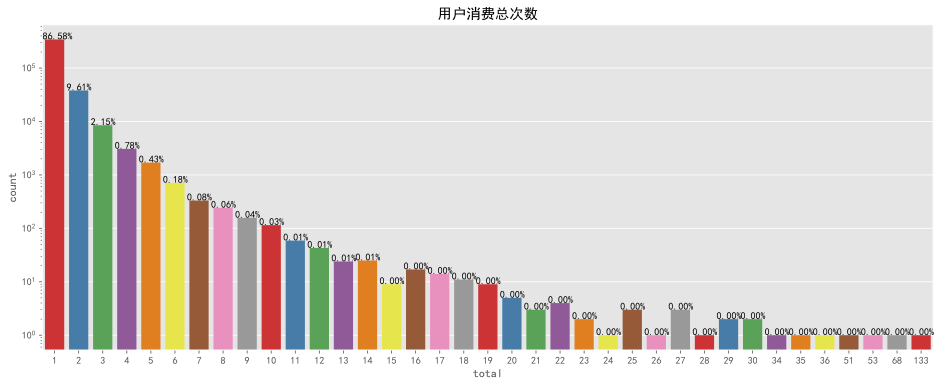

In [21]:
# 单个用户消费总次数可视化
tbc_box = total_buy_count.reset_index()
fig, axes = plt.subplots(figsize=(16, 6))
axes.set_yscale('log')
sns.countplot(x=tbc_box['total'], data=tbc_box, palette='Set1')
for p in axes.patches:
    axes.annotate('{:.2f}%'.format(100*p.get_height() /
                                   len(tbc_box['total'])), (p.get_x()-0.1, p.get_height()))
plt.title('用户消费总次数')

计算周期内大部分用户购物次数在6次以下，可适当推广，完善购物体验，提高用户消费次数；购物次数较多的用户应提高其满意度，提高存留率。

In [22]:
print('复购率为 %0.3f%%' % (re_buy_rate*100))

复购率为 13.419%


复购率较低，应加强老用户召回机制，提升购物体验。也可能是数据量较少，无法解释完整购物周期。

## 用户行为在时间维度的分布

In [23]:
# 日活跃人数
daily_active_user = behavior.groupby('date')['user_id'].nunique()
# 日消费人数
daily_buy_user = behavior[behavior['type'] == 'pay'].groupby('date')[
    'user_id'].nunique()
# 日消费人数占比
proportion_of_buyer = daily_buy_user / daily_active_user
# 日消费总次数
daily_buy_count = behavior[behavior['type'] == 'pay'].groupby('date')[
    'type'].count()
# 消费用户日人均消费次数
consumption_per_buyer = daily_buy_count / daily_buy_user

C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '日消费人数占比')

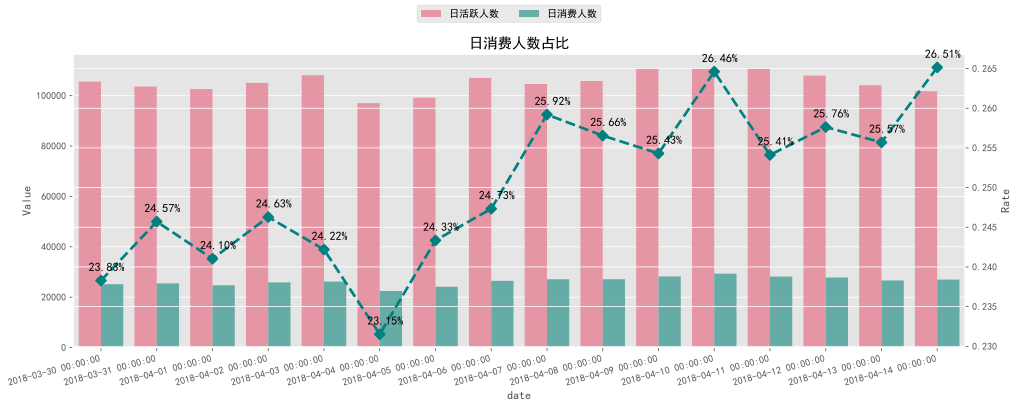

In [24]:
# 日消费人数占比可视化
# 柱状图数据
pob_bar = (pd.merge(daily_active_user, daily_buy_user, on='date').reset_index()
           .rename(columns={'user_id_x': '日活跃人数', 'user_id_y': '日消费人数'})
           .set_index('date').stack().reset_index()
           .rename(columns={'level_1': 'Variable', 0: 'Value'}))
# 线图数据
pob_line = (proportion_of_buyer.reset_index()
            .rename(columns={'user_id': 'Rate'}))

fig1 = plt.figure(figsize=[16, 6])
ax1 = fig1.add_subplot(111)
ax2 = ax1.twinx()
fig1.autofmt_xdate(rotation=15)

sns.barplot(x='date', y='Value', hue='Variable',
            data=pob_bar, ax=ax1, alpha=0.8, palette='husl')

ax1.legend().set_title('')
ax1.legend().remove()

sns.pointplot(pob_line['date'], pob_line['Rate'], ax=ax2,
              markers='D', linestyles='--', color='teal')
x = list(range(0, 16))
for a, b in zip(x, pob_line['Rate']):
    plt.text(a+0.1, b+0.001, '%.2f%%' %
             (b*100), ha='center', va='bottom', fontsize=12)

fig1.legend(loc='upper center', ncol=2)
plt.title('日消费人数占比')

C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '消费用户日均消费次数')

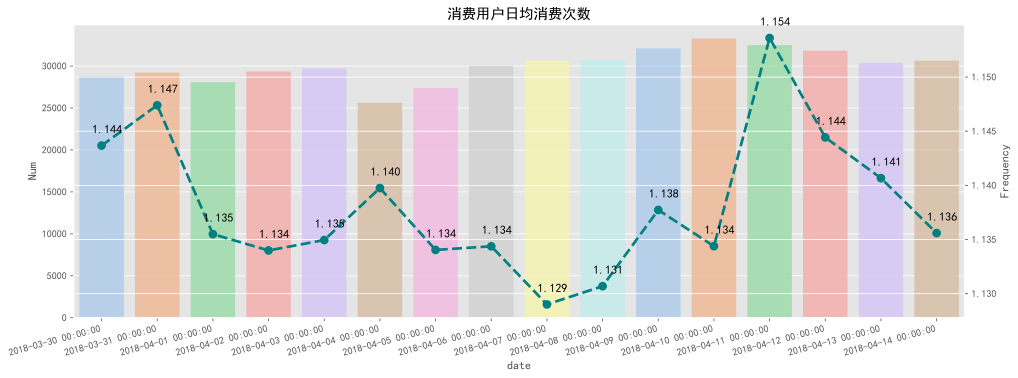

In [25]:
# 消费用户日均消费次数可视化

# 柱状图
cpb_bar = (daily_buy_count.reset_index().rename(columns={'type': 'Num'}))
# 线图数据
cpb_line = (consumption_per_buyer.reset_index().rename(
    columns={0: 'Frequency'}))

fig2 = plt.figure(figsize=[16, 6])
ax3 = fig2.add_subplot(111)
ax4 = ax3.twinx()
fig2.autofmt_xdate(rotation=15)

sns.barplot(x='date', y='Num', data=cpb_bar,
            ax=ax3, alpha=0.8, palette='pastel')
sns.pointplot(cpb_line['date'], cpb_line['Frequency'],
              ax=ax4, marker='D', linestyles='--', color='teal')

x = list(range(0, 16))
for a, b in zip(x, cpb_line['Frequency']):
    plt.text(a+0.1, b+0.001, '%.3f' % b, ha='center', va='bottom', fontsize=12)
plt.title('消费用户日均消费次数')

日消费人数在25000以上，日均消费次数大于1次

In [26]:
# 没人高活跃用户(日操作大于3)
dau3_df = behavior.groupby(['date', 'user_id'])['type'].count().reset_index()
dau3_df = dau3_df[dau3_df['type'] >= 3]
dau3_num = dau3_df.groupby('date')['user_id'].nunique()

C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '每日高活跃用户数')

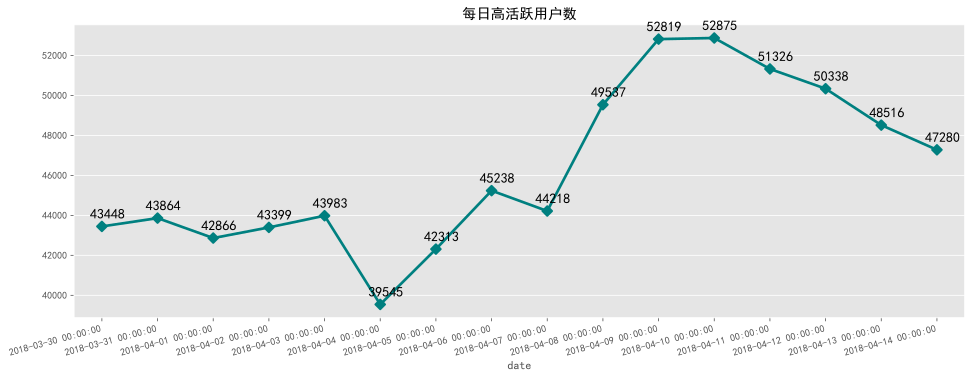

In [27]:
fig, ax = plt.subplots(figsize=[16, 6])
fig.autofmt_xdate(rotation=15)  # 当x轴太拥挤的时，可以让指标自适应

sns.pointplot(dau3_num.index, dau3_num.values,
              markers='D', linestyle='--', color='teal')
x = list(range(0, 16))
for a, b in zip(x, dau3_num.values):
    plt.text(a+0.1, b+300, '%i' % b, ha='center', va='bottom', fontsize=14)
plt.title('每日高活跃用户数')

每日高活跃用户大部分在4万以上，2018-04-04之前数量较为平稳，之后数量一直攀升，9号之后开始下降，推测是营销活动产生的。

In [28]:
# 高活跃用户累计活跃天数分布
dau3_cumsum = dau3_df.groupby('user_id')['date'].count()

C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '高活跃用户累计活跃天数分布')

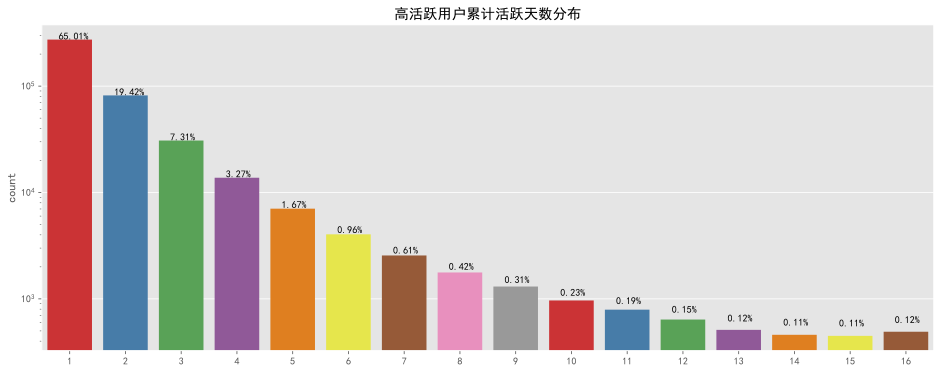

In [29]:
fig, ax = plt.subplots(figsize=[16, 6])
ax.set_yscale('log')

sns.countplot(dau3_cumsum.values, palette='Set1')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height() /
                                 len(dau3_cumsum.values)), (p.get_x()+0.2, p.get_height()+100))
plt.title('高活跃用户累计活跃天数分布')

大部分高活跃用户累计活跃天数在6天以下，但也存在超级活跃的用户，对累计天数较高的用户要推出连续登陆奖励来维持对平台的黏性，对累计天数较低的用户要适当推出召回活动。

In [30]:
# 每日浏览量
pv_daily = behavior[behavior['type'] == 'pv'].groupby('date')[
    'user_id'].count()
# 每日访客数
uv_daily = behavior.groupby('date')['user_id'].nunique()

C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '每日浏览量')

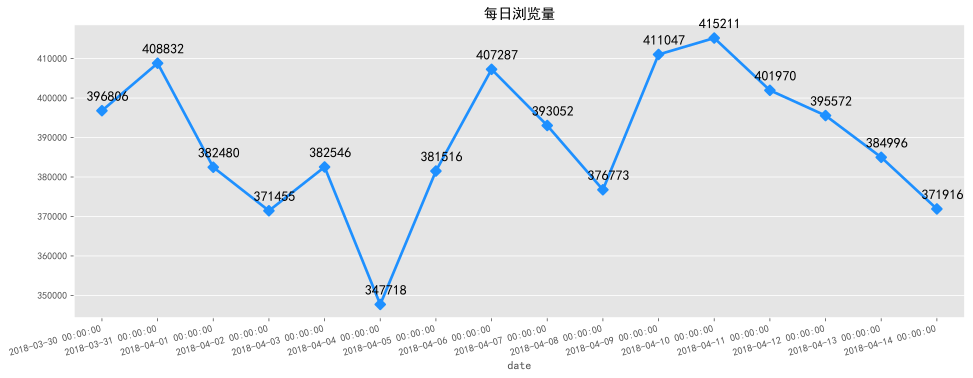

In [31]:
fig, ax = plt.subplots(figsize=[16, 6])
fig.autofmt_xdate(rotation=15)  # 当x轴太拥挤的时，可以让指标自适应
sns.pointplot(pv_daily.index, pv_daily.values, markers='D',
              linstyles='--', color='dodgerblue')
x = list(range(0, 16))
for a, b in zip(x, pv_daily.values):
    plt.text(a+0.1, b+2000, '%i' % b, ha='center', va='bottom', fontsize=14)

plt.title('每日浏览量')

C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '每日访客数')

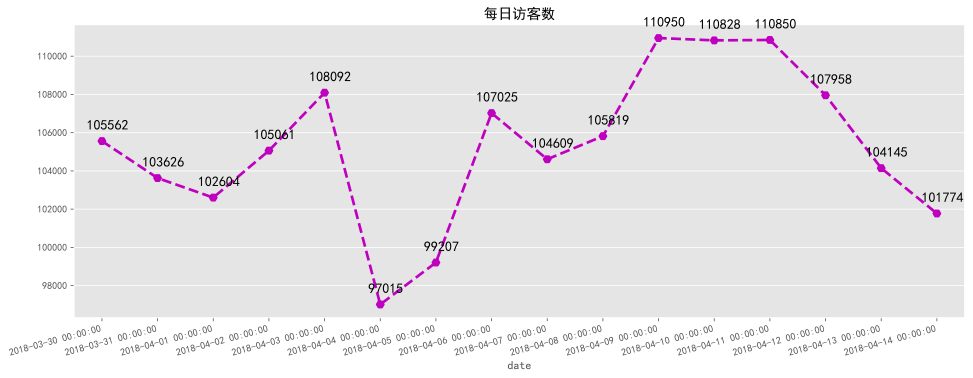

In [32]:
fig, ax = plt.subplots(figsize=[16, 6])
fig.autofmt_xdate(rotation=15)  # 当x轴太拥挤的时，可以让指标自适应
sns.pointplot(uv_daily.index, uv_daily.values,
              markers='H', linestyles='--', color='m')
x = list(range(0, 16))
for a, b in zip(x, uv_daily.values):
    plt.text(a+0.1, b+500, '%i' % b, ha='center', va='bottom', fontsize=14)

plt.title('每日访客数')

浏览量和访客数变化趋势大致相同，2018-04-04前后波动较大，推测是节假日营销活动或推广拉新活动带来的影响。

In [33]:
# 每时浏览量
pv_hourly = behavior[behavior['type'] == 'pv'].groupby('hour')[
    'user_id'].count()
# 每时访客数
uv_hourly = behavior.groupby('hour')['user_id'].nunique()

C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '浏览量随小时变化可视化')

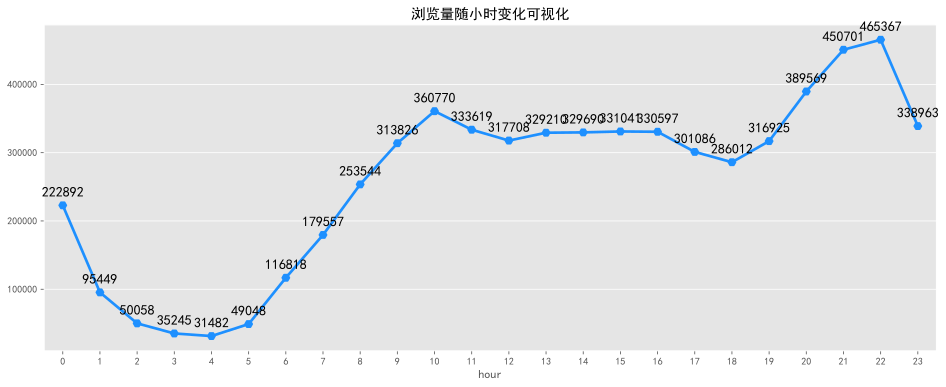

In [34]:
fig, ax = plt.subplots(figsize=[16, 6])

sns.pointplot(pv_hourly.index, pv_hourly.values, markers='H',
              linestyle='--', color='dodgerblue')
for a, b in zip(pv_hourly.index, pv_hourly.values):
    plt.text(a, b+10000, '%i' % b, ha='center', va='bottom', fontsize=14)

plt.title('浏览量随小时变化可视化')

C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '浏览量随小时变化可视化')

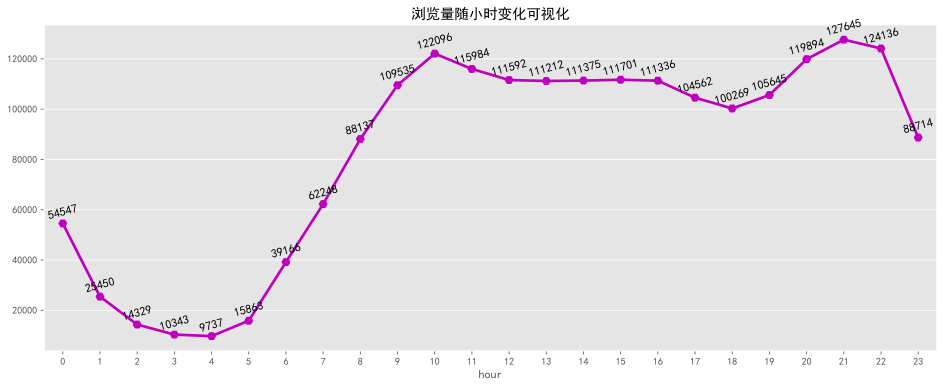

In [35]:
fig, ax = plt.subplots(figsize=[16, 6])

sns.pointplot(uv_hourly.index, uv_hourly.values,
              markers='H', linestyle='--', color='m')
for a, b in zip(uv_hourly.index, uv_hourly.values):
    plt.text(a, b+1000, '%i' % b, ha='center',
             va='bottom', fontsize=12, rotation=15)

plt.title('浏览量随小时变化可视化')

* 在凌晨1点到凌晨5点之间，大部分用户正在休息，整体活跃度较低。
* 在凌晨5点到10点用户开始起床工作，活跃度逐渐增加，之后趋于平稳。
* 下午6点之后大部分人恢复空闲，迎来了第二波攀升。
* 在晚上8点中到达高峰，随后逐渐下降。


* 可以考虑在上午9点及晚上8点增大商品推广力度，加大营销活动投入。
* 1点到5点之间适合做系统维护。

In [36]:
# 用户各操作随小时变化
type_detail_hour = pd.pivot_table(
    columns='type', index='hour', data=behavior, aggfunc=np.size, values='user_id')
# 用户各操作随星期变化
type_detail_weekday = pd.pivot_table(
    columns='type', index='weekday', data=behavior, aggfunc=np.size, values='user_id')
type_detail_weekday = type_detail_weekday.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [37]:
tdh_line = type_detail_hour.stack().reset_index().rename(columns={0: 'Value'})
tdw_line = type_detail_weekday.stack(
).reset_index().rename(columns={0: 'Value'})
tdh_line = tdh_line[~(tdh_line['type'] == 'pv')]
tdw_line = tdw_line[~(tdw_line['type'] == 'pv')]

Text(0.5, 1.0, '用户操作随小时变化')

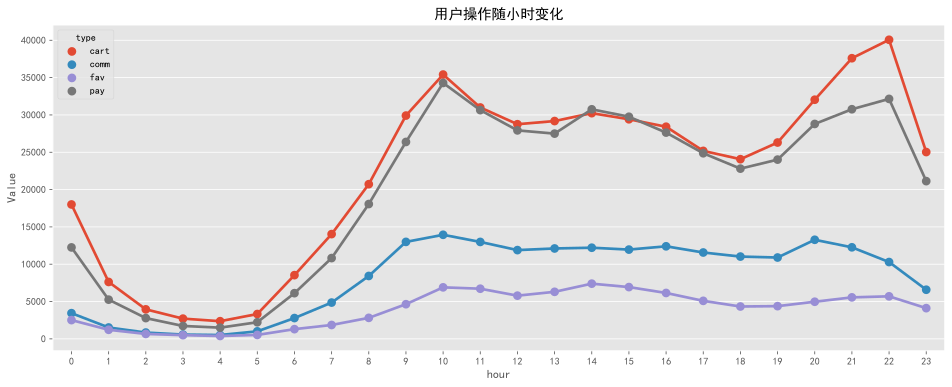

In [38]:
fig, ax = plt.subplots(figsize=[16, 6])
sns.pointplot(x='hour', y='Value', hue='type', data=tdh_line, linestyle='--')
plt.title('用户操作随小时变化')

* 用户操作随小时变化规律和PV、UV相似。
* 加入购物车和付款两条曲线贴合紧密，说明大部分用户下官加入购物车之后直接购买。
* 关注数相对较少，可以根据购物车内容精准推送。
* 评论数较少，说明用户不热衷于对购物体验进行反馈，可以设置一些奖励制度提高用户黏性

Text(0.5, 1.0, '用户操作随星期变化')

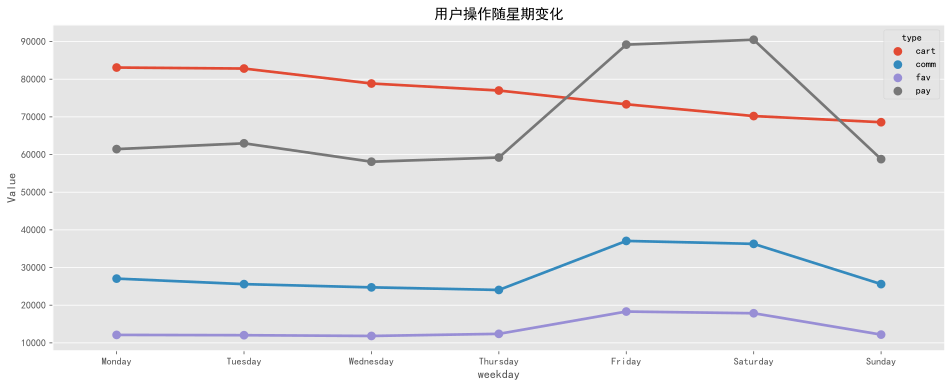

In [39]:
fig, ax = plt.subplots(figsize=[16, 6])
sns.pointplot(x='weekday', y='Value', hue='type',
              data=tdw_line, linestyle='--')
plt.title('用户操作随星期变化')

周一至周四用户工作，操作较为平稳；周五至周六进入休息日，用户操作明显增多，周日又恢复正常。

## 用户行为转化漏斗

In [42]:
import math

from pyecharts import options as opts
from pyecharts.charts import Funnel
from pyecharts.globals import CurrentConfig, NotebookType

CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB

In [44]:
# 用户整体行为分布
type_dis = behavior['type'].value_counts().reset_index()
type_dis['rate'] = round((type_dis['type']/type_dis['type'].sum()), 3)

In [45]:
type_dis.style.bar(color='skyblue', subset=['rate'])

,index,type,rate
0,pv,6229177,0.826000
1,cart,533890,0.071000
2,pay,480149,0.064000
3,comm,200399,0.027000
4,fav,96779,0.013000


用户整体行为中，大部分是浏览，实际支付操作仅占6.4%，此外用户评论及收藏的行为占比也较低。

In [46]:
df_con = behavior[['user_id', 'sku_id', 'action_time', 'type']]

In [47]:
df_pv = df_con[df_con['type'] == 'pv']
df_fav = df_con[df_con['type'] == 'fav']
df_cart = df_con[df_con['type'] == 'cart']
df_pay = df_con[df_con['type'] == 'pay']

df_pv_uid = df_con[df_con['type'] == 'pv']['user_id'].unique()
df_fav_uid = df_con[df_con['type'] == 'fav']['user_id'].unique()
df_cart_uid = df_con[df_con['type'] == 'cart']['user_id'].unique()
df_pay_uid = df_con[df_con['type'] == 'pay']['user_id'].unique()

### pv-buy

In [48]:
fav_cart_list = set(df_fav_uid) | set(df_cart_uid)
pv_pay_df = pd.merge(left=df_pv, right=df_pay, how='inner', on=[
                     'user_id', 'sku_id'], suffixes=('_pv', '_pay'))
pv_pay_df = pv_pay_df[(~pv_pay_df['user_id'].isin(fav_cart_list)) & (
    pv_pay_df['action_time_pv'] < pv_pay_df['action_time_pay'])]

In [49]:
uv = behavior['user_id'].nunique()
pv_pay_num = pv_pay_df['user_id'].nunique()
pv_pay_data = pd.DataFrame({'type': ['浏览', '付款'], 'num': [uv, pv_pay_num]})
pv_pay_data['conversion_rates'] = (
    round((pv_pay_data['num'] / pv_pay_data['num'][0]), 4) * 100)

In [50]:
attr1 = list(pv_pay_data.type)
values1 = list(pv_pay_data.conversion_rates)
data1 = [[attr1[i], values1[i]] for i in range(len(attr1))]

In [52]:
pv_pay = (Funnel(opts.InitOpts(width="600px", height="300px"))
          .add(
              series_name="",
              data_pair=data1,
              gap=2,
              tooltip_opts=opts.TooltipOpts(
                  trigger="item", formatter="{b} : {c}%"),
              label_opts=opts.LabelOpts(is_show=True, position="inside"),
              itemstyle_opts=opts.ItemStyleOpts(
                  border_color="#fff", border_width=1)
)
    .set_global_opts(title_opts=opts.TitleOpts(title="用户行为转化漏斗图"))
    #           .render("funnel_chart.html")
)
pv_pay.load_javascript()

C:\Users\10990\anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


In [53]:
pv_pay.render_notebook()

### pv-cart-pay

In [54]:
pv_cart_df = pd.merge(df_pv, df_cart, how='inner', on=[
                      'user_id', 'sku_id'], suffixes=('_pv', '_cart'))
pv_cart_df = pv_cart_df[pv_cart_df['action_time_pv']
                        < pv_cart_df['action_time_cart']]
pv_cart_df = pv_cart_df[~pv_cart_df['user_id'].isin(df_fav_uid)]
pv_cart_pay_df = pd.merge(left=pv_cart_df, right=df_pay,
                          how='inner', on=['user_id', 'sku_id'])
pv_cart_pay_df = pv_cart_pay_df[pv_cart_pay_df['action_time_cart']
                                < pv_cart_pay_df['action_time']]

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
uv = behavior['user_id'].nunique()
pv_cart_num = pv_cart_df['user_id'].nunique()
pv_cart_pay_num = pv_cart_pay_df['user_id'].nunique()
pv_cart_pay_data = pd.DataFrame({'type': ['浏览', '加购', '付款'], 'num': [
                                uv, pv_cart_num, pv_cart_pay_num]})
pv_cart_pay_data['conversion_rates'] = (
    round((pv_cart_pay_data['num'] / pv_cart_pay_data['num'][0]), 4) * 100)

In [56]:
attr2 = list(pv_cart_pay_data.type)
values2 = list(pv_cart_pay_data.conversion_rates)
data2 = [[attr2[i], values2[i]] for i in range(len(attr2))]

C:\Users\10990\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [57]:
pv_cart_buy = (Funnel(opts.InitOpts(width="600px", height="300px"))
               .add(
    series_name="",
    data_pair=data2,
    gap=2,
    tooltip_opts=opts.TooltipOpts(trigger="item", formatter="{b} : {c}%"),
    label_opts=opts.LabelOpts(is_show=True, position="inside"),
    itemstyle_opts=opts.ItemStyleOpts(border_color="#fff", border_width=1)
)
    .set_global_opts(title_opts=opts.TitleOpts(title="用户行为转化漏斗图"))
)
pv_cart_buy.load_javascript()

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\10990\anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


In [58]:
pv_cart_buy.render_notebook()

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### pv-fav-pay

In [60]:
pv_fav_df = pd.merge(left=df_pv, right=df_fav, how='inner', on=[
                     'user_id', 'sku_id'], suffixes=('_pv', '_fav'))
pv_fav_df = pv_fav_df[pv_fav_df['action_time_pv']
                      < pv_fav_df['action_time_fav']]
pv_fav_df = pv_fav_df[~pv_fav_df['user_id'].isin(df_cart_uid)]
pv_fav_pay_df = pd.merge(left=pv_fav_df, right=df_pay,
                         how='inner', on=['user_id', 'sku_id'])
pv_fav_pay_df = pv_fav_pay_df[pv_fav_pay_df['action_time_fav']
                              < pv_fav_pay_df['action_time']]

In [61]:
uv = behavior['user_id'].nunique()
pv_fav_num = pv_fav_df['user_id'].nunique()
pv_fav_pay_num = pv_fav_pay_df['user_id'].nunique()
pv_fav_pay_data = pd.DataFrame(
    {'type': ['浏览', '收藏', '付款'], 'num': [uv, pv_fav_num, pv_fav_pay_num]})
pv_fav_pay_data['conversion_rates'] = (
    round((pv_fav_pay_data['num'] / pv_fav_pay_data['num'][0]), 4) * 100)

In [62]:
attr3 = list(pv_fav_pay_data.type)
values3 = list(pv_fav_pay_data.conversion_rates)
data3 = [[attr3[i], values3[i]] for i in range(len(attr3))]

C:\Users\10990\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [63]:
pv_fav_buy = (Funnel(opts.InitOpts(width="600px", height="300px"))
              .add(
    series_name="",
    data_pair=data3,
    gap=2,
    tooltip_opts=opts.TooltipOpts(
                trigger="item", formatter="{b} : {c}%"),
    label_opts=opts.LabelOpts(is_show=True, position="inside"),
    itemstyle_opts=opts.ItemStyleOpts(
        border_color="#fff", border_width=1)
)
    .set_global_opts(title_opts=opts.TitleOpts(title="用户行为转化漏斗图"))
)
pv_fav_buy.load_javascript()

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\10990\anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


In [64]:
pv_fav_buy.render_notebook()

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### pv-fav-vart-pay

In [67]:
pv_fav = pd.merge(left=df_pv, right=df_fav, how='inner', on=[
                  'user_id', 'sku_id'], suffixes=('_pv', '_fav'))
pv_fav = pv_fav[pv_fav['action_time_pv'] < pv_fav['action_time_fav']]
pv_fav_cart = pd.merge(left=pv_fav, right=df_cart,
                       how='inner', on=['user_id', 'sku_id'])
pv_fav_cart = pv_fav_cart[pv_fav_cart['action_time_fav']
                          < pv_fav_cart['action_time']]
pv_fav_cart_pay = pd.merge(left=pv_fav_cart, right=df_pay, how='inner', on=[
                           'user_id', 'sku_id'], suffixes=('_cart', '_pay'))
pv_fav_cart_pay = pv_fav_cart_pay[pv_fav_cart_pay['action_time_cart']
                                  < pv_fav_cart_pay['action_time_pay']]

In [68]:
uv = behavior['user_id'].nunique()
pv_fav_n = pv_fav['user_id'].nunique()
pv_fav_cart_n = pv_fav_cart['user_id'].nunique()
pv_fav_cart_pay_n = pv_fav_cart_pay['user_id'].nunique()
pv_fav_cart_pay_data = pd.DataFrame({'type': ['浏览', '收藏', '加购', '付款'], 'num': [
                                    uv, pv_fav_n, pv_fav_cart_n, pv_fav_cart_pay_n]})
pv_fav_cart_pay_data['conversion_rates'] = (
    round((pv_fav_cart_pay_data['num'] / pv_fav_cart_pay_data['num'][0]), 4) * 100)

In [69]:
attr4 = list(pv_fav_cart_pay_data.type)
values4 = list(pv_fav_cart_pay_data.conversion_rates)
data4 = [[attr4[i], values4[i]] for i in range(len(attr4))]

C:\Users\10990\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [70]:
pv_fav_buy = (Funnel(opts.InitOpts(width="600px", height="300px"))
              .add(
    series_name="",
    data_pair=data4,
    gap=2,
    tooltip_opts=opts.TooltipOpts(
                trigger="item", formatter="{b} : {c}%"),
    label_opts=opts.LabelOpts(is_show=True, position="inside"),
    itemstyle_opts=opts.ItemStyleOpts(
        border_color="#fff", border_width=1)
)
    .set_global_opts(title_opts=opts.TitleOpts(title="用户行为转化漏斗图"))
)
pv_fav_buy.load_javascript()

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\10990\anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


In [71]:
pv_fav_buy.render_notebook()

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


比较四种不同的转换方式，最有效的转换路径为**浏览直接付款**，转换率为21.46%，其次为**浏览加购付款**，转换率为12.47%，可以发现，随着结算方式的复杂，转换率越来越低。

加购的方式比收藏的方式转换率更高，是因为购物车接口更方便进行不同商品的比较，而收藏方式更加繁琐。

* 可以优化商品搜索功能，提高商品搜索准确度，减少用户搜索时间，方便直接进行购买。
* 根据用户喜好在首页推荐商品，提高用户下单欲望，提供一键购物等简化购物步骤的功能。
* 客服留意加购用户，适时推出优惠福利，提高用户购买转化率。
* 利用消费时间间隔，推出限时优惠，缩短用户付款时间。


### pv-cart-pay

In [72]:
pcp_interval = pv_cart_pay_df.groupby(['user_id', 'sku_id']).apply(
    lambda x: (x.action_time.min()-x.action_time_cart.min())).reset_index()
pcp_interval['interval'] = pcp_interval[0].apply(lambda x: x.seconds)/3600
pcp_interval['interval'] = pcp_interval['interval'].apply(
    lambda x: math.ceil(x))

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'pv-cart-pay路径用户消费时间间隔')

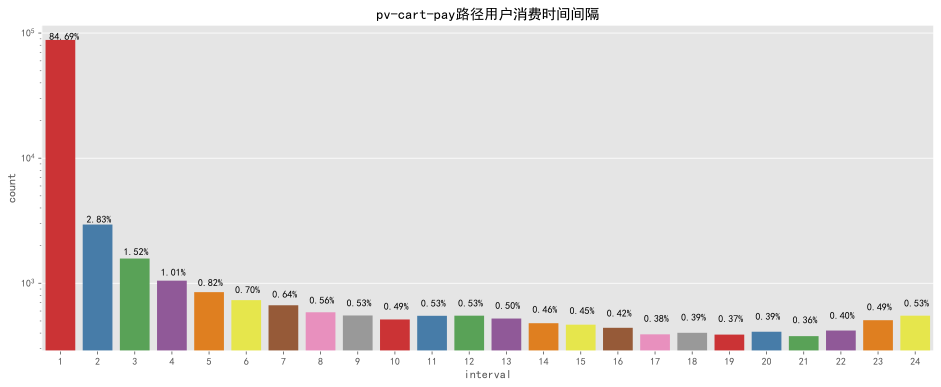

In [77]:
fig, ax = plt.subplots(figsize=[16, 6])
sns.countplot(pcp_interval['interval'], palette='Set1')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height() /
                                 len(pcp_interval['interval'])), (p.get_x()+0.1, p.get_height()+100))
ax.set_yscale('log')
plt.title('pv-cart-pay路径用户消费时间间隔')

### pv-fav-pay

In [78]:
pfp_interval = pv_fav_pay_df.groupby(['user_id', 'sku_id']).apply(
    lambda x: (x.action_time.min()-x.action_time_fav.min())).reset_index()
pfp_interval['interval'] = pfp_interval[0].apply(lambda x: x.seconds)/3600
pfp_interval['interval'] = pfp_interval['interval'].apply(
    lambda x: math.ceil(x))

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\10990\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'pv-fav-pay路径用户消费时间间隔')

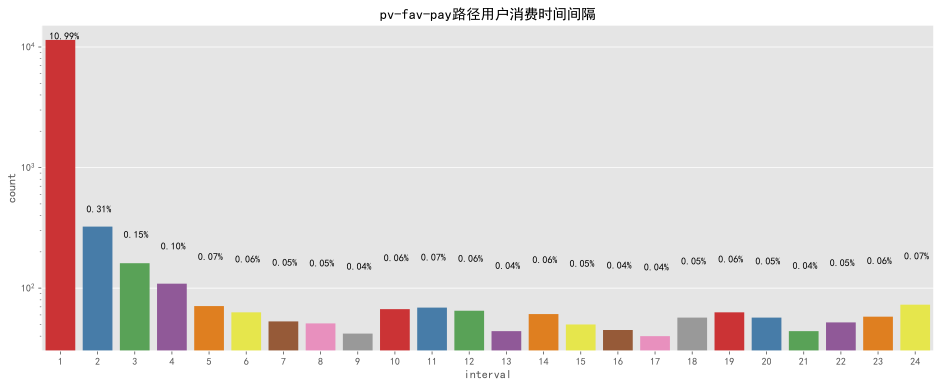

In [79]:
fig, ax = plt.subplots(figsize=[16, 6])
sns.countplot(pfp_interval['interval'], palette='Set1')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height() /
                                 len(pcp_interval['interval'])), (p.get_x()+0.1, p.get_height()+100))
ax.set_yscale('log')
plt.title('pv-fav-pay路径用户消费时间间隔')

两种路径下的大部分用户均在4小时内完成了支付，大部分用户的购物意向较为明确，也侧面说明网站的商品分类布局和购物结算方式比较合理。

## 用户存留率分析

In [80]:
# 存留率
first_day = datetime.date(datetime.strptime('2018-03-30', '%Y-%m-%d'))
fifth_day = datetime.date(datetime.strptime('2018-04-03', '%Y-%m-%d'))
tenth_day = datetime.date(datetime.strptime('2018-04-08', '%Y-%m-%d'))
fifteenth_day = datetime.date(datetime.strptime('2018-04-13', '%Y-%m-%d'))

# 第一天新用户数
user_num_first = behavior[behavior['date'] == first_day]['user_id'].to_frame()
# 第五天存留用户数
user_num_fifth = behavior[behavior['date'] == fifth_day]['user_id'].to_frame()
# 第十天存留用户数
user_num_tenth = behavior[behavior['date'] == tenth_day]['user_id'].to_frame()
# 第十五天存留用户数
user_num_fifteenth = behavior[behavior['date']
                              == fifteenth_day]['user_id'].to_frame()

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
# 第五天留存率
fifth_day_retention_rate = round((pd.merge(
    user_num_first, user_num_fifth).nunique())/(user_num_first.nunique()), 4).user_id
# 第十天留存率
tenth_day_retention_rate = round((pd.merge(
    user_num_first, user_num_tenth).nunique())/(user_num_first.nunique()), 4).user_id
# 第十五天留存率
fifteenth_day_retention_rate = round((pd.merge(
    user_num_first, user_num_fifteenth).nunique())/(user_num_first.nunique()), 4).user_id

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
retention_rate = pd.DataFrame({'n日后留存率': ['第五天留存率', '第十天留存率', '第十五天留存率'],
                               'Rate': [fifth_day_retention_rate, tenth_day_retention_rate, fifteenth_day_retention_rate]})

C:\Users\10990\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, '用户存留率')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


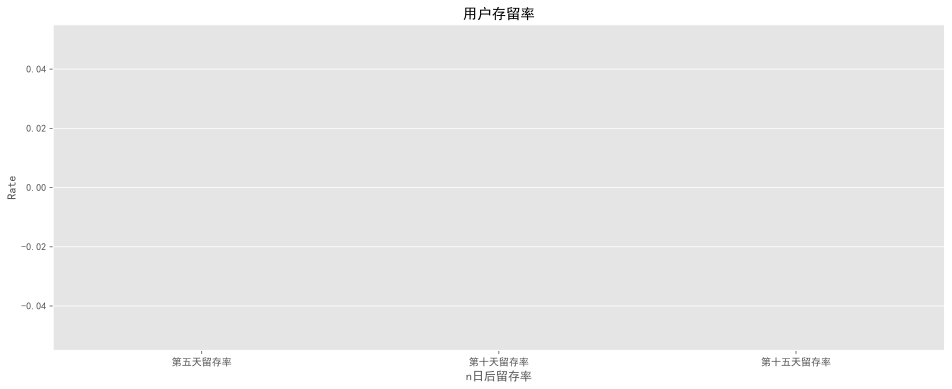

In [85]:
fig,ax = plt.subplots(figsize=[16,6])
sns.barplot(x='n日后留存率',y='Rate',data=retention_rate,palette='Set1')
x=list(range(0,3))
for a,b in zip(x,retention_rate['Rate']):
    plt.text(a,b+0.001,'%.2f%%' %(b+100),ha='center',va='bottom',fontsize=12)

plt.title('用户留存率')